
# REPRODUCIBILITY NOTEBOOK 

***
## ARTICLE: Transferability and explainability of deep learning emulators for regional climate model projections: Perspectives for future applications

### AUTHORS: J. Baño-Medina, M. Iturbide, J. Fernández and J.M. Gurtiérrez

We provide the Python code and the data sources for reproducing the main results of the article. In this notebook, we use the NorESM Global Climate Model (GCM) as a case study. Results for the rest of GCM-RCM combinations are produced in the same manner. 

We provide the functions developed in Python (folder `baseFunctions`), as well as the current notebook (`2024_Bano-Medina_et_al_AIES.ipynb` in the `notebook` folder): 

├── baseFunctions\
│   ├── auxiliaryFunctions.py\
│   ├── buildEmulator.py\
│   ├── deepmodel.py\
│   ├── emulate.py\
│   ├── explainability.py\
│   ├── figures.py\
│   └── integratedGradients.py\
└── notebook\
│   └── **2024_Bano-Medina_et_al_AIES.ipynb**

***

## DATA SOURCES



The code here provided works by pointing to a `data` folder where the ready-to-use NetCDF files for both predictors (`data/predictors`) and the predictand (`data/predictand`) would be stored. The `predictors` folder would contain data for the upscaled ALADIN63 driven by the NorESM GCM, and the different GCMs (NorESM, MPI, CNRM). Each file groups a set of multiple variables (the final subset of these variables is selected in the *Parameter Setting* section of this notebook). Other data such as the land-sea-mask or templates for producing the model outputs are also used.

All data sources are publicly available through the Earth System Grid Federation (ESGF). **See the *Data and Methods* section in the article** for details on how the predictors and predictand data files were prepared from source. 
 

***
**NOTE**: In order to get the data ready to run the code chunks of this notebook (without any editing of the source code), the data files must organized in the same folder of the notebook according to the following structure and naming :


├── data\
│   ├── land_sea_mask\
│   │   ├── landseamask_ALADIN63_ALP12.nc\
│   │   └── lsm_ald63.nc\
│   ├── predictand\
│   │   ├── tas_cnrm-ald63_historical_1996-2005.nc\
│   │   ├── tas_cnrm-ald63_rcp85_2041-2050.nc\
│   │   ├── tas_cnrm-ald63_rcp85_2090-2099.nc\
│   │   ├── tas_mpi-ald63_historical_1996-2005.nc\
│   │   ├── tas_mpi-ald63_rcp85_2041-2050.nc\
│   │   ├── tas_mpi-ald63_rcp85_2090-2099.nc\
│   │   ├── tas_noresm-ald63_historical_1996-2005.nc\
│   │   ├── tas_noresm-ald63_rcp85_2041-2050.nc\
│   │   └── tas_noresm-ald63_rcp85_2090-2099.nc\
│   ├── predictors\
│   │   ├── gcm\
│   │   │   ├── x_cnrm_historical_1996-2005.nc\
│   │   │   ├── x_cnrm_rcp85_2041-2050.nc\
│   │   │   ├── x_cnrm_rcp85_2090-2099.nc\
│   │   │   ├── x_mpi_historical_1996-2005.nc\
│   │   │   ├── x_mpi_rcp85_2041-2050.nc\
│   │   │   ├── x_mpi_rcp85_2090-2099.nc\
│   │   │   ├── x_noresm_historical_1996-2005.nc\
│   │   │   ├── x_noresm_rcp85_2041-2050.nc\
│   │   │   └── x_noresm_rcp85_2090-2099.nc\
│   │   └── upscaledrcm\
│   │   │   ├── x_noresm-ald63_historical_1996-2005.nc\
│   │   │   ├── x_noresm-ald63_rcp85_2041-2050.nc\
│   │   │   └── x_noresm-ald63_rcp85_2090-2099.nc\
│   └── templates\
│   │   ├── template.nc\
│   │   ├── template_predictand.nc\
│   │   └── template_predictor.nc

***

## LIBRARIES AND FUNCTIONS

Library loading:

In [1]:
import os
import xarray as xr
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

2024-04-12 18:59:35.644849: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 18:59:35.673459: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 18:59:35.808593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 18:59:35.808625: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 18:59:35.809344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Functions developed for this experiment are available at folder `baseFunctions`: 

In [2]:
exec(open("../baseFunctions/buildEmulator.py").read())
exec(open("../baseFunctions/emulate.py").read())
exec(open("../baseFunctions/deepmodel.py").read())
exec(open("../baseFunctions/figure.py").read())
exec(open("../baseFunctions/auxiliaryFunctions.py").read())

## PARAMETER SETTING

In [3]:
# Predictor variables
vars = ['zg500', 'zg700',
        'hus500', 'hus700', 'hus850',
        'ua500', 'ua700', 'ua850',
        'va500', 'va700', 'va850',
        'ta500', 'ta700', 'ta850']
# RCM model (ALADIN63 in this example). 
rcm = 'ald63'
# Network topology
topology = 'deepesd'

## BUILD THE EMULATORS

The model is learned with the function `buildEmulator`. Here this is done in a loop for both the Perfect Prog (PP) and the Model Output Statistics (MOS) approaches. When `type` is set to 'MOS-E', training predictors are taken from the specified Global Climate Model (GCM) in the `gcm` parameter (NorESM in this example). When `type = 'PP-E'` the upscaled RCM (RCM-U) driven by the specified GCM is used.

This function saves the built emulators in a `models` folder by default, i.e.:

├── models\
│   ├── deepesd-tas-noresm-ald63-MOS-E.h5\
│   └── deepesd-tas-noresm-ald63-PP-E.h5


In [4]:
gcm = 'noresm'

In [ ]:
# Calibration of statistical emulator (PP-E and MOS-E)
for type in ['PP-E', 'MOS-E']:
        buildEmulator(gcm = gcm,
                      rcm = rcm,
                      vars = vars,
                      type = type,
                      topology = topology)

## EMULATE IN CROSS-VALIDATION AND SOFT-TRANSFERABILITY MODE

Using the `emulate` base function, and continuing with the NorESM GCM, we perform the different predictions that correspond to the `cross-validation` and the `soft-transferability` shown in **Figure 4 in the manuscript**. The predictand is the same in all cases (RCM-tas) but the predictors change depending on the approach, here indicated in the commented lines (##) at the beginning of each execution of the `emulate` function. The outputs are saved in the `predictions` folder, i.e.:

├── predictions\
│   ├── hard-trans\
│   └── soft-trans\
│   │   ├── MOS-E_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc\
│   │   ├── PP-E-bc_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc\
│   │   ├── PP-E_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc\
│   │   └── PP-E-perfect_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc


In [5]:
## PP-E Perfect model: train predictors = RCM-U, test predictors = RCM-U.
emulate(newdata = '../data/predictors/upscaledrcm/x_' + gcm + '-ald63_rcp85_2041-2050.nc',
        emulator = gcm + '-ald63',
        rcm = 'ald63',
        topology = topology,
        vars = vars,
        bias_correction = False,
        type = 'PP-E',
        outputFileName = '../predictions/soft-trans' + '/PP-E-perfect_' + topology + '_' + 'tas_alp12_' + gcm + '-ald63_rcp85_2041-2050.nc')
## PP-E GCM: train predictors = RCM-U, test predictors = driving GCM.
emulate(newdata = '../data/predictors/gcm/x_' + gcm + '_rcp85_2041-2050.nc',
        emulator = gcm + '-ald63',
        rcm = 'ald63',
        topology = topology,
        vars = vars,
        bias_correction = False,
        type = 'PP-E',
        outputFileName = '../predictions/soft-trans' + '/PP-E_' + topology + '_' + 'tas_alp12_' + gcm + '-ald63_rcp85_2041-2050.nc')
## PP-E GCM-BC: train predictors = RCM-U, test predictors = driving GCM bias adjusted.
emulate(newdata = '../data/predictors/gcm/x_' + gcm + '_rcp85_2041-2050.nc',
        emulator = gcm + '-ald63',
        rcm = 'ald63',
        topology = topology,
        vars = vars,
        bias_correction = True,
        bias_correction_base = gcm,
        type = 'PP-E',
        outputFileName = '../predictions/soft-trans' + '/PP-E-bc_' + topology + '_' + 'tas_alp12_' + gcm + '-ald63_rcp85_2041-2050.nc')
## MOS-E: train predictors = driving GCM, test predictors = driving GCM.
emulate(newdata = '../data/predictors/gcm/x_' + gcm + '_rcp85_2041-2050.nc',
        emulator = gcm,
        rcm = 'ald63',
        topology = topology,
        vars = vars,
        bias_correction = False,
        type = 'MOS-E',
        outputFileName = '../predictions/soft-trans' + '/MOS-E_' + topology + '_' + 'tas_alp12_' + gcm + '-ald63_rcp85_2041-2050.nc')

scaling...
115/115 [==============================] - 1s 6ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/soft-trans/PP-E-perfect_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc
scaling...
115/115 [==============================] - 1s 6ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/soft-trans/PP-E_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc
bias correction...
scaling...
115/115 [==============================] - 1s 6ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/soft-trans/PP-E-bc_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc
scaling...
115/115 [==============================] - 1s 5ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/soft-trans/MOS-E_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc


We create the panels of Figure 4 using the base function `figure4`, where we specify the GCM in the `groundtruth` parameter. The parameters of this function are used to point to the data files involved in the calculation of the bias, the correlation, and the RMSE, which are calculated internally by the function. We also specify parameter `outputFileName` to save the Figure.

In [17]:
# Figure save
figure4(groundtruth = ['noresm'],
        topology = topology,
        figsize = (18, 9),
        outputFileName = '../figures/figure_soft-transferability.pdf')

## EMULATE IN HARD-TRANSFERABILITY MODE

We will now apply `emulate` to other (non-driving) GCMs: `prediction_gcms = ['cnrm','mpi']` in this case study. This corresponds to the hard-transferability mode (see Figure 6 in the manuscript). The outputs are saved in the `predictions` folder together with the soft-transferability predictions generated above, i.e.:

├── predictions\
│   ├── hard-trans\
│   │   ├── MOS-E_deepesd_tas_alp12_PREDGCM:cnrm_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc\
│   │   ├── MOS-E_deepesd_tas_alp12_PREDGCM:mpi_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc\
│   │   ├── PP-E_deepesd_tas_alp12_PREDGCM:cnrm_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc\
│   │   └── PP-E_deepesd_tas_alp12_PREDGCM:mpi_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc\
│   └── soft-trans\
│   │   ├── MOS-E_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc\
│   │   ├── PP-E-bc_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc\
│   │   ├── PP-E_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc\
│   │   └── PP-E-perfect_deepesd_tas_alp12_noresm-ald63_rcp85_2041-2050.nc

In [5]:
training_gcm = 'noresm'

In [8]:
# Statistical emulators - transferability to other GCMs
for prediction_gcm in prediction_gcms:
    ## PP-E: train predictors = RCM-U, test predictors = the new GCM.
    emulate(newdata = '../data/predictors/gcm/x_' + prediction_gcm + '_rcp85_2041-2050.nc',
            emulator = training_gcm + '-ald63',
            rcm = 'ald63',
            topology = topology,
            vars = vars,
            bias_correction = False,
            type = 'PP-E',
            outputFileName = '../predictions/hard-trans' + '/PP-E_' + topology + '_' + 'tas_alp12_' + 'PREDGCM:' + prediction_gcm + '_TRAGCM:' + training_gcm + '_RCM:ald63_rcp85_2041-2050.nc')
    ## MOS-E: train predictors = driving GCM, test predictors = the new GCM.
    emulate(newdata = '../data/predictors/gcm/x_' + prediction_gcm + '_rcp85_2041-2050.nc',
            emulator = training_gcm,
            rcm = 'ald63',
            topology = topology,
            vars = vars,
            bias_correction = False,
            type = 'MOS-E',
            outputFileName = '../predictions/hard-trans' + '/MOS-E_' + topology + '_' + 'tas_alp12_' + 'PREDGCM:' + prediction_gcm + '_TRAGCM:' + training_gcm + '_RCM:ald63_rcp85_2041-2050.nc')


scaling...
115/115 [==============================] - 1s 6ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/hard-trans/PP-E_deepesd_tas_alp12_PREDGCM:cnrm_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc
scaling...
115/115 [==============================] - 1s 5ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/hard-trans/MOS-E_deepesd_tas_alp12_PREDGCM:cnrm_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc
scaling...
115/115 [==============================] - 1s 5ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/hard-trans/PP-E_deepesd_tas_alp12_PREDGCM:mpi_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc
scaling...
115/115 [==============================] - 1s 5ms/step


<string>:63: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


../predictions/hard-trans/MOS-E_deepesd_tas_alp12_PREDGCM:mpi_TRAGCM:noresm_RCM:ald63_rcp85_2041-2050.nc


Function `figure6` reproduces panels of the biases resulting from the hard-transferability mode. We specify parameter `outputFileName` to save the Figure.

In [78]:
# Figure
figure6(training_gcm = training_gcm,
        figsize = (10,20),
        topology = 'deepesd',
        outputFileName = '../figures/figure_hard-transferability.pdf')

## EXPLAINABILITY

For this section additional base functions are used, which are defined in `integratedGradients.py` and `explainability.py`:

In [5]:
exec(open("../baseFunctions/integratedGradients.py").read())
exec(open("../baseFunctions/explainability.py").read())

The following parameter setting leads to the first and third columns of figure 8 in the manuscript, this is, the saliency maps corresponding to NorESM for location 1 (in the Alps) and for both PP and MOS approaches:

In [22]:
# Select sites
# Alps: i=52, j=53; Poland: i=90, j=100
sites = [[52,53]]
topology = 'deepesd'
type = ['PP-E', 'MOS-E']
vars_to_plot = ['hus850', 'ua850', 'va850', 'ta700', 'ta850']
months = ['year'] # use 12 for winter 
outputDir = "../saliency/"

These parameters are passed to function `compute_saliency`. For the above parameter setting, two NetCDF files are generated and stored in the `saliency` folder, i.e.:

└── saliency\
│   ├── SALIENCY_deepesd_tas_alp12_noresm-ald63_MOS-E_site3073_month:year.nc\
│   └── SALIENCY_deepesd_tas_alp12_noresm-ald63_PP-E_site3073_month:year.nc


In [ ]:
compute_saliency(sites, type, gcm, rcm, months, vars = vars, outputDir = outputDir)

Function `saliency_maps` plot the corresponding maps pointing to the created NetCDFs by means of additional parameter definition:

site:3073type:PP-E_gcm:noresm_var:hus850
site:3073type:PP-E_gcm:noresm_var:ua850
site:3073type:PP-E_gcm:noresm_var:va850
site:3073type:PP-E_gcm:noresm_var:ta700
site:3073type:PP-E_gcm:noresm_var:ta850
site:3073type:MOS-E_gcm:noresm_var:hus850
site:3073type:MOS-E_gcm:noresm_var:ua850
site:3073type:MOS-E_gcm:noresm_var:va850
site:3073type:MOS-E_gcm:noresm_var:ta700
site:3073type:MOS-E_gcm:noresm_var:ta850


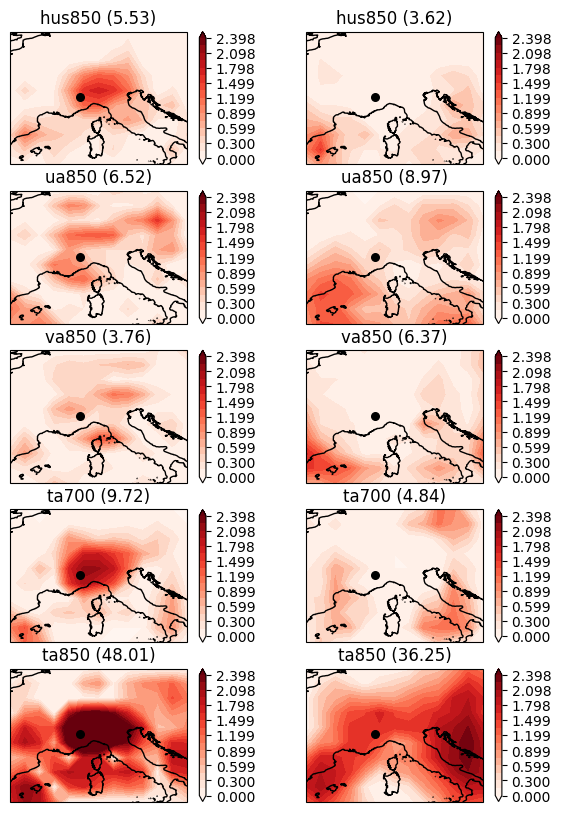

In [36]:
exec(open("../baseFunctions/explainability.py").read())
saliency_maps(vars = vars_to_plot,
              site = [52,53],
              gcms = ['noresm'],
              month = 'year',
              types = ['PP-E', 'MOS-E'],
              figsize = (7,10),
              inputDir = "../saliency/",
              outputDir = "../figures/",
              by_row = len(vars_to_plot),
              by_column = len(sites)*len(type),
              type_plot = 'contour',
              epsilon = 1)

## Data sources and Acknowledgements

Both GCM and RCM data used in this study ---from the Coupled Model Intercomparison Project Phase 5 (CMIP5) and CORDEX, respectively,--- are openly available from the Earth System Grid Federation (ESGF) portal. The code needed to implement the DeepESD model can be found in a Zenodo repository (Baño-Medina et al. 2022a; https://doi.org/10.5281/zenodo.6828303) associated to a previous publication (Baño-Medina et al. 2022b).

This work is part of IMPETUS4CHANGE, funded by the European Union's Horizon Europe research and innovation programme under grant agreement No 101081555. J.M.G and J.F acknowledge support from MCIN/AEI/10.13039/501100011033, which funded projects ATLAS (PID2019-111481RB-I00) and CORDyS (PID2020-116595RB-I00), respectively.